In [42]:
import re
import random
import pandas as pd
import hashlib

In [43]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [44]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,126.081888,14.009099,21.605005,9
Email Auth and Security,233.737595,58.434399,81.377337,4
"Jane Eyre, Bronte",448.878605,56.109826,83.667142,8
Azure VM + Developer,652.110823,19.179730,32.097488,34
Azure AD Authentication,895.619418,74.634952,157.782881,12
TSQL,896.923912,37.371830,52.683564,24
RAG Project,924.393864,102.710429,257.169996,9
Logging in Python,1080.752651,77.196618,122.178295,14
Terraform,1610.054875,89.447493,153.275482,18
Azure Private DNS,1663.642657,87.560140,164.623830,19


# Histogram

sum of ages: ~51872.17


<Axes: >

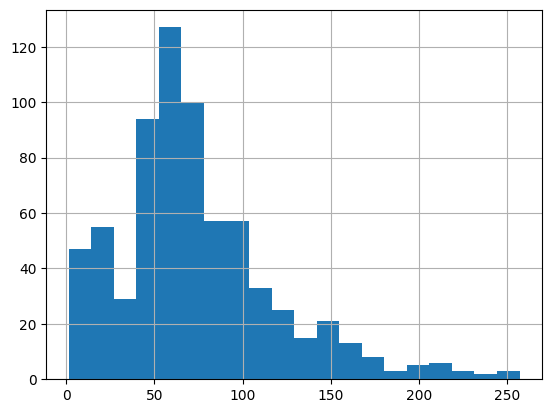

In [45]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~51872.17


<Axes: >

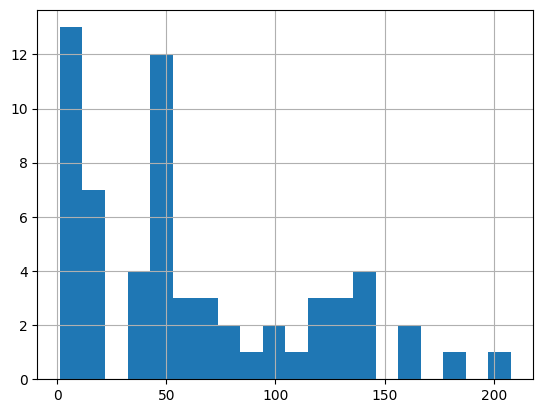

In [46]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [47]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [48]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [49]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [50]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [51]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [52]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [53]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [54]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [55]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [56]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 703
Total card age: 51872.17


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
2,RAG Project,pytest.mark.asyncio\nA decorator that marks a ...,b5113e6bd7ecba984bd0fc0ede2f0238,257.169996,102.710429,-257.169996,924.393864,0.410719,0,0,-257.169996
3,RAG Project,Fixture\nA reusable setup block in pytest that...,4f93846aa03e6a3631c874b835eb0809,114.280569,102.710429,-257.169996,924.393864,0.410719,3,0,-114.280569
4,RAG Project,OIDC / Entra ID\nAuthentication standards used...,9082722a055e4e3254a6625a0d508851,60.444585,102.710429,-257.169996,924.393864,0.410719,6,0,-60.444585
5,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,249.163465,103.074997,-249.163465,2679.949913,0.200857,0,0,-249.163465
485,Azure DevOps Pipelines,What does the jobs keyword in Azure DevOps YAM...,e436a16940083e3eca36fd4243904778,145.046007,103.074997,-249.163465,2679.949913,0.200857,3,0,-145.046007
7,Azure DevOps Pipelines,How do you use stages with dependencies in Azu...,1cbd7ec636a3ee01792d8abf542f89e3,128.759867,103.074997,-249.163465,2679.949913,0.200857,6,0,-128.759867
8,Azure DevOps Pipelines,How do you run a pipeline on a self-hosted age...,0ac1ed550c9daa2946b919787429b4fc,103.832204,103.074997,-249.163465,2679.949913,0.200857,9,0,-103.832204
9,Azure DevOps Pipelines,What is a Deployment Pool in Azure DevOps?\nAn...,b2eaffd4fe48ffdcde8eff2111eaa421,95.294540,103.074997,-249.163465,2679.949913,0.200857,12,0,-95.294540
10,Azure DevOps Pipelines,How do you add a manual approval gate before a...,542695935dc8f2953c36ad4dc6412f9d,86.195396,103.074997,-249.163465,2679.949913,0.200857,15,0,-86.195396
11,Azure DevOps Pipelines,What does the trigger keyword do in an Azure D...,a097384f075f0b7c7dc948ba0445fbf7,71.393879,103.074997,-249.163465,2679.949913,0.200857,18,0,-71.393879


## Card Count

In [57]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [58]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [59]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
348,Azure Developer Associate,App Configuration doesn't version key values a...,c5b1da2f26c3dc2ad56cbaba6c51b9ed,1.282875,62.662967,-207.760906,3885.103953,0.051203,61,1,-1.282875
209,C# Basics,.NET uses a garbage collector that automatical...,43bedaac447bb0b9a8a6f14b650981e4,3.110476,71.960120,-122.190125,2230.763727,0.212598,30,0,-3.110476
579,Azure Developer Associate,Configuration data stored in an App Configurat...,22293608d8680b7f657f335dbf029202,3.722408,62.662967,-207.760906,3885.103953,0.051203,60,0,-3.722408
105,Azure Developer Associate,For the .NET SDK for Azure Cosmos DB for NoSQL...,e2ff6f3c584a2c6c5faf78dcae2eb263,3.825839,62.662967,-207.760906,3885.103953,0.051203,59,2,-3.825839
346,Azure Developer Associate,Azure App Configuration encrypts sensitive inf...,fc0360a578522e808e4d680619664a40,4.031582,62.662967,-207.760906,3885.103953,0.051203,58,1,-4.031582
104,Azure Developer Associate,"In Azure App Configuration,\nFeature flag: A f...",8bcb1de29c054bd4964e31961734bbbd,4.544722,62.662967,-207.760906,3885.103953,0.051203,57,0,-4.544722
578,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,f5da4a10007b58ba8af2aaafb7b97a48,4.877369,62.662967,-207.760906,3885.103953,0.051203,56,2,-4.877369
604,JavaScript Concepts,When ... appears on the right-hand side of an ...,10bddd23b38f376d792526c3e14f9065,5.428632,50.255257,-170.701463,3769.144259,0.426750,74,2,-5.428632
347,Azure Developer Associate,Feature management is a modern software-develo...,0bbf18293899f4165444a093909158a0,6.411390,62.662967,-207.760906,3885.103953,0.051203,55,1,-6.411390
577,Azure Developer Associate,"In Azure App Configuration,\nFeature manager: ...",c901a14baf95edb2e2619bb15f279978,6.563563,62.662967,-207.760906,3885.103953,0.051203,54,0,-6.563563


In [60]:
existing_cards.head(10).sum()

head                   RAG ProjectRAG ProjectRAG ProjectAzure DevOps ...
body                   pytest.mark.asyncio\nA decorator that marks a ...
hash                   b5113e6bd7ecba984bd0fc0ede2f02384f93846aa03e6a...
age                                                          1311.580508
subject_mean_age                                             1029.656265
subject_highest_age                                         -2515.654241
subject_age_sum                                             21532.830983
head_random_roll                                                2.638155
count                                                                 72
n_fold                                                                 0
neg_age                                                     -1311.580508
dtype: object

In [61]:
existing_cards['age'].mean()

73.78686890643945